<a href="https://colab.research.google.com/github/PhaniChandraSekhar/AIML_Practice/blob/main/Stock_prediction_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance==0.2.12
!pip install tensorflow==2.12.0


In [2]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
import os

In [13]:

df = pd.read_csv('/content/sample_data/aapl_stock_data.csv', index_col='Date', parse_dates=True)
# Select the 'Close' price as the target variable
data = df[['Close']].values

# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size, :], data[train_size:len(data), :]

# Create the dataset with lookback
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
df.head()


,Open,High,Low,Close,Volume,PERatio,EPS,MarketCap
Date,,,,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300,35.85,6.43,3535123251000
1999-11-02,78.00,81.69,77.31,80.25,3564600,35.85,6.43,3535123251000
1999-11-03,81.62,83.25,81.00,81.50,2932700,35.85,6.43,3535123251000
1999-11-04,82.06,85.37,80.62,83.62,3384700,35.85,6.43,3535123251000
1999-11-05,84.62,88.37,84.00,88.31,3721500,35.85,6.43,3535123251000


In [15]:
# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# CNN Model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(LSTM(units=50))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(units=1))
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Train LSTM model
model_lstm.fit(X_train, Y_train, epochs=100, batch_size=32)

# Train CNN model
model_cnn.fit(X_train, Y_train, epochs=100, batch_size=32)

# Make predictions
predictions_lstm = model_lstm.predict(X_test)
predictions_cnn = model_cnn.predict(X_test)

# Invert predictions to get actual stock prices
predictions_lstm = scaler.inverse_transform(predictions_lstm)
predictions_cnn = scaler.inverse_transform(predictions_cnn)
Y_test = scaler.inverse_transform([Y_test])

Epoch 1/100
154/154 [==============================] - 17s 70ms/step - loss: 0.0053
Epoch 2/100
154/154 [==============================] - 11s 69ms/step - loss: 0.0019
Epoch 3/100
154/154 [==============================] - 12s 77ms/step - loss: 0.0018
Epoch 4/100
154/154 [==============================] - 10s 62ms/step - loss: 0.0017
Epoch 5/100
154/154 [==============================] - 11s 69ms/step - loss: 0.0013
Epoch 6/100
154/154 [==============================] - 11s 73ms/step - loss: 0.0014
Epoch 7/100
154/154 [==============================] - 11s 70ms/step - loss: 0.0013
Epoch 8/100
154/154 [==============================] - 11s 73ms/step - loss: 0.0012
Epoch 9/100
154/154 [==============================] - 10s 65ms/step - loss: 0.0011
Epoch 10/100
154/154 [==============================] - 12s 79ms/step - loss: 0.0011
Epoch 11/100
154/154 [==============================] - 11s 69ms/step - loss: 0.0011
Epoch 12/100
154/154 [==============================] - 11s 70ms/step - lo

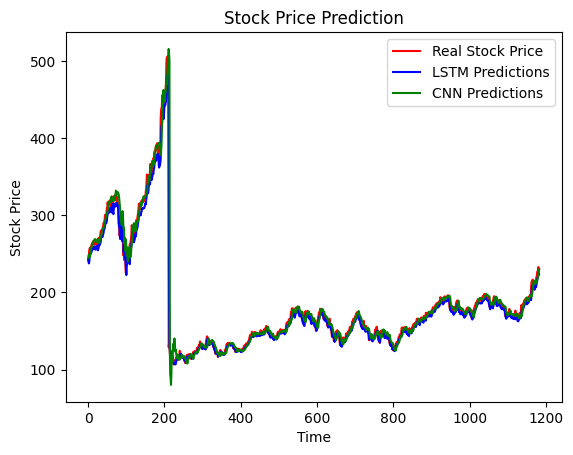

In [17]:
# Plot the results
plt.plot(Y_test[0], color='red', label='Real Stock Price')
plt.plot(predictions_lstm, color='blue', label='LSTM Predictions')
plt.plot(predictions_cnn, color='green', label='CNN Predictions')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()